# Tweet Sentiment Analysis
---

In [91]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

#Import WordCloud
from wordcloud import WordCloud, STOPWORDS
from scipy import stats

In [92]:
# Remove unwanted patterns
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tywang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tywang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [93]:
#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

#from sklearn.cross_validation import StratifiedKFold, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

In [94]:
# Tweet Cleaner
stopwordlist = set(stopwords.words("english"))
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def remove_stopwords(tweet):
    new_tweet = [w for w in tweet.split() if not w in stopwordlist] 
    return (" ").join(new_tweet) 

def remove_specialchar(tweet):
    #Converts HTML tags to the characters they represent
    soup = BeautifulSoup(tweet, "html.parser")
    tweet = soup.get_text()
    
    #Convert www.* or https?://* to empty strings
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet) 
    #Convert @username to empty strings
    tweet = re.sub('@[^\s]+','',tweet)

    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('[\n]+', ' ', tweet)
    
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    #Trims the tweet
    tweet = tweet.strip('\'"')
    
    #Remove all char not alphabets, num or whitespaces
    tweet = re.sub('[^A-Za-z ]+','', tweet)
    
    return tweet


#Attempts to replace every individual word with it's root word.
def stemmer_lemmatizer(tweet):
    word_list = []
    for word in tweet.split():
        word = ps.stem(word)
        word = wordnet_lemmatizer.lemmatize(word)
        word_list.append(word)
    return (" ".join(word_list))

#for testing
#Tweets = df_oba['Tweet'].values
#for i in range(len(Tweets)):
#    print(i)
#    b = remove_specialchar(Tweets[i])
#    a = stemmer_lemmatizer(b)
#    print('last', a)
#    print('last', remove_stopwords(a))


In [95]:
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",
    
    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    #punctuation:'',
    '\s+':' ', # replace multi space with one single space
}

In [96]:
def load_csv():
    xls = pd.ExcelFile('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/training-Obama-Romney-tweets.xlsx')
    df1 = pd.read_excel(xls, 'Obama')
    df2 = pd.read_excel(xls, 'Romney')
    return df1, df2

def data_parse(df):
    
    #drop missing values and rename columns
    df = df.iloc[1:, 3:5]
    df = df.rename(columns = {'Anootated tweet':'Tweet', 'Unnamed: 4': 'Class'})
    # Drop rows if Tweet is empty
    df.dropna(subset = ['Tweet'], inplace=True)
    print(df.shape)
    
    #dtype class label
    df['Class'] = df['Class'].astype(str)
    df['Tweet'] = df['Tweet'].astype(str)
    print(df.info())
    print(df['Class'].value_counts())

    # Extract rows where class labels -1, 0, 1
    df = df[ (df['Class'] == '0') |(df['Class'] == '-1') | (df['Class'] == '1') ]
    print('After extracting:', df.shape)
    
    tweets = df['Tweet'].values
    targets = df['Class'].values
    
    return tweets, targets

def tweet_cleaning(tweets, flag):
    
    for i in range(len(tweets)):
        #print(i)
        #print('original:', tweets[i])
        tweets[i] = tweets[i].lower()
        #if tweets[i] in abbr_dict.keys():
        #    tweets[i].replace(abbr_dict,regex=True,inplace=True)
        
        #tweets[i] = ' '.join(filter(lambda x: x.isalpha(), ''.join(tweets[i])))
        tweets[i] = remove_specialchar(tweets[i])
        if flag == 'stem_lem':
            tweets[i] = stemmer_lemmatizer(tweets[i])
        if flag == 'rm_stopwords':
            tweets[i] = remove_stopwords(tweets[i])
        if flag == 'all':
            tmp = remove_specialchar(tweets[i])
            tmp = stemmer_lemmatizer(tmp)
            tweets[i] = remove_stopwords(tmp)
        #tmp = remove_specialchar(tweets[i])
        #tmp = stemmer_lemmatizer(tmp)
        #tweets[i] = remove_stopwords(tmp)
        #print('final:', tweets[i])
    return tweets

In [97]:
# tweets_oba[10]

In [98]:
def save_dataset(tweets, targets, tw_name, tar_name):
    print('Saving training dataset...')
    
    #Create Saving Files
    if not os.path.exists('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData'):
        os.makedirs('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData')
        
    np.save('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/' + tw_name + '.npy', tweets)
    np.save('/Users/tywang/XCODEproject/CS583/CS583_ResearchProject/TrainData/' + tar_name + '.npy', targets)

    print('Saved parsed dataset')
    

In [99]:
def wordcloud(data,backgroundcolor = 'white', width = 400, height = 150):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [100]:
df1, df2 = load_csv()

## Obama's Tweets

In [101]:
tweets_oba, targets_oba = data_parse(df1)
tweets_oba.shape, targets_oba.shape

(7196, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7196 entries, 1 to 7198
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7196 non-null   object
 1   Class   7196 non-null   object
dtypes: object(2)
memory usage: 168.7+ KB
None
0             1977
-1            1968
1             1679
2             1543
irrevelant      23
nan              5
irrelevant       1
Name: Class, dtype: int64
After extracting: (5624, 2)


((5624,), (5624,))

In [102]:
tweets_oba

array(["Kirkpatrick, who wore a baseball cap embroidered with Barack Obama's signature and had the hangdog look of Jason segel - Courier Journal",
       '#<e>obama</e> debates that Cracker Ass Cracker tonight... I will be tuned in! #TeamObama',
       '@Hollivan @hereistheanswer  Youre missing the point  Im afraid you do not understand the bigger picture if you dont care if Obama re elected',
       ...,
       ' The Reason <e>Ann Romney</e> And <e>Michelle Obama</e> Matched <a>Last Night</a>: <e>Michelle Obama</e> and <e>Ann Romney</e> showed up to last nig... http://t.co/lRXmH4Ka                           ',
       ' <e>Obama</e> Kenakan Cincin Syahadat Sejak SMA? http://t.co/HQw4rfqx                           ',
       ' Bitches be like "Obama<3" bitches just want <a>food stamps</a> lmao _Ù÷â                           '],
      dtype=object)

## WordCloud for Oba_Tweet

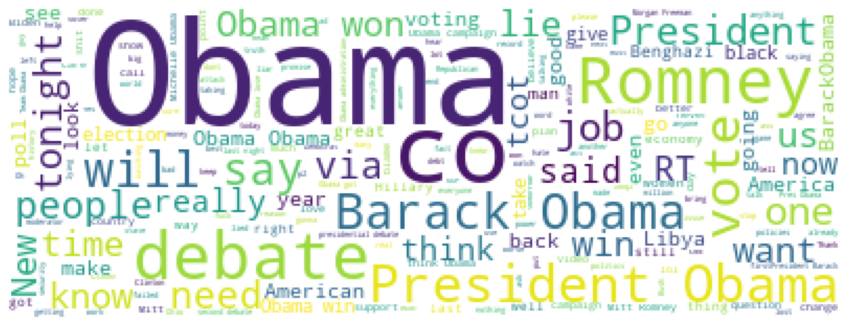

In [103]:
#Original Tweet
wordcloud(''.join(tweets_oba))

['kirkpatrick who wore a baseball cap embroidered with barack obamas signature and had the hangdog look of jason segel  courier journal'
 'obama debates that cracker ass cracker tonight i will be tuned in teamobama'
 ' youre missing the point im afraid you do not understand the bigger picture if you dont care if obama re elected'
 ...
 ' the reason ann romney and michelle obama matched last night michelle obama and ann romney showed up to last nig '
 ' obama kenakan cincin syahadat sejak sma '
 ' bitches be like obama bitches just want food stamps lmao  ']


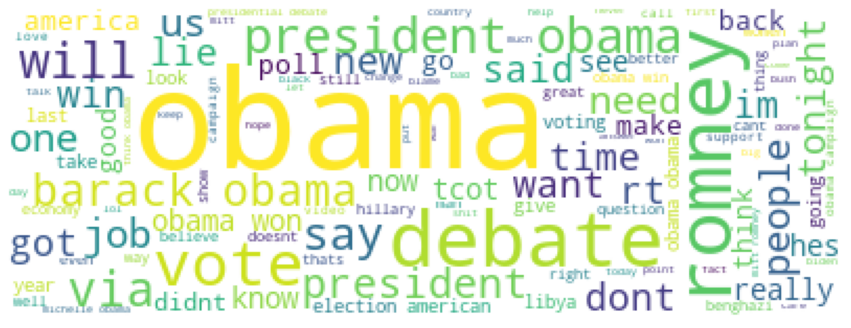

In [104]:
# Remove special char only
oba_rmspecial = tweet_cleaning(tweets_oba, '')
print(oba_rmspecial)
wordcloud(''.join(oba_rmspecial))

['kirkpatrick who wore a basebal cap embroid with barack obama signatur and had the hangdog look of jason segel courier journal'
 'obama debat that cracker as cracker tonight i will be tune in teamobama'
 'your miss the point im afraid you do not understand the bigger pictur if you dont care if obama re elect'
 ...
 'the reason ann romney and michel obama match last night michel obama and ann romney show up to last nig'
 'obama kenakan cincin syahadat sejak sma'
 'bitch be like obama bitch just want food stamp lmao']


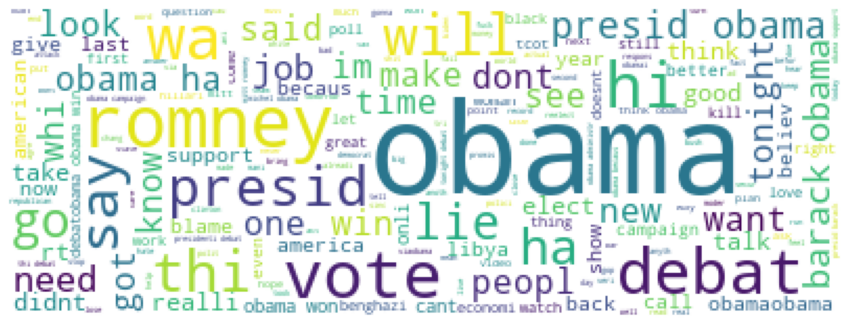

In [105]:
# Tweet stemmer_lemmatizer
oba_stemlem = tweet_cleaning(tweets_oba, 'stem_lem')
print(oba_stemlem)
wordcloud(''.join(oba_stemlem))

['kirkpatrick wore basebal cap embroid barack obama signatur hangdog look jason segel courier journal'
 'obama debat cracker cracker tonight tune teamobama'
 'miss point im afraid understand bigger pictur dont care obama elect' ...
 'reason ann romney michel obama match last night michel obama ann romney show last nig'
 'obama kenakan cincin syahadat sejak sma'
 'bitch like obama bitch want food stamp lmao']


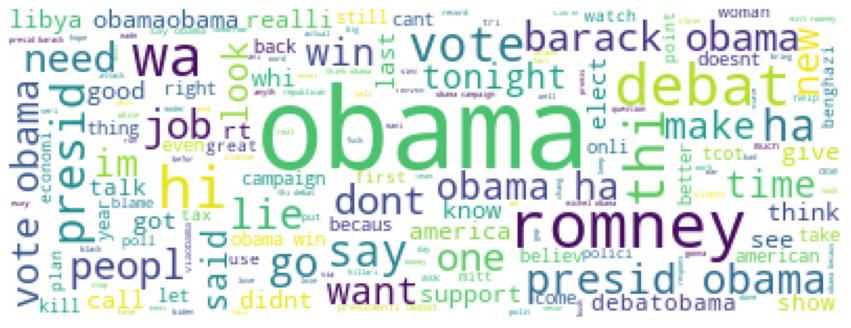

In [106]:
# Remove stopword
oba_rmstop = tweet_cleaning(tweets_oba, 'rm_stopwords')
print(oba_rmstop)
wordcloud(''.join(oba_rmstop))

['kirkpatrick wore baseb cap embroid barack obama signatur hangdog look jason segel courier journal'
 'obama debat cracker cracker tonight tune teamobama'
 'miss point im afraid understand bigger pictur dont care obama elect' ...
 'reason ann romney michel obama match last night michel obama ann romney show last nig'
 'obama kenakan cincin syahadat sejak sma'
 'bitch like obama bitch want food stamp lmao']


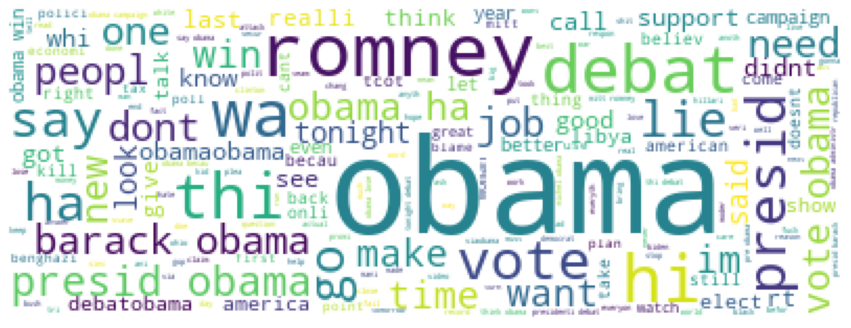

In [107]:
# All cleaning methods
oba_cleanall = tweet_cleaning(tweets_oba, 'all')
print(oba_cleanall)
wordcloud(''.join(oba_cleanall))

In [108]:
save_dataset(oba_cleanall, targets_oba, 'tweets_oba', 'targets_oba')

Saving training dataset...
Saved parsed dataset


## Romney's Tweets

In [109]:
tweets_rom, targets_rom = data_parse(df2)
tweets_rom.shape, targets_rom.shape

(7200, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7200 entries, 1 to 7200
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweet   7200 non-null   object
 1   Class   7200 non-null   object
dtypes: object(2)
memory usage: 168.8+ KB
None
-1      2893
0       1680
2       1351
1       1075
!!!!     169
nan       29
IR         3
Name: Class, dtype: int64
After extracting: (5648, 2)


((5648,), (5648,))

In [110]:
tweets_rom

array(["Insidious!<e>Mitt Romney</e>'s Bain Helped Philip Morris Get U.S. High Schoolers <a>Hooked On Cigarettes</a> http://t.co/nMKuFcUq via @HuffPostPol",
       '.@WardBrenda @shortwave8669 @allanbourdius you mean like <e>romney </e><a>cheated in primary</a>?',
       "<e>Mitt Romney</e> still doesn't <a>believe</a> that we <a>have a black president</a>.",
       ...,
       'el 59 por ciento de las mujeres blancas casadas respaldan a <e>Romney</e>"""',
       '"And they brought us a whole binder of women"""" oh <e>Romney</e>"""',
       '@FoxNews <e>Romney</e>won"""'], dtype=object)

## WordCloud for Rom_tweet

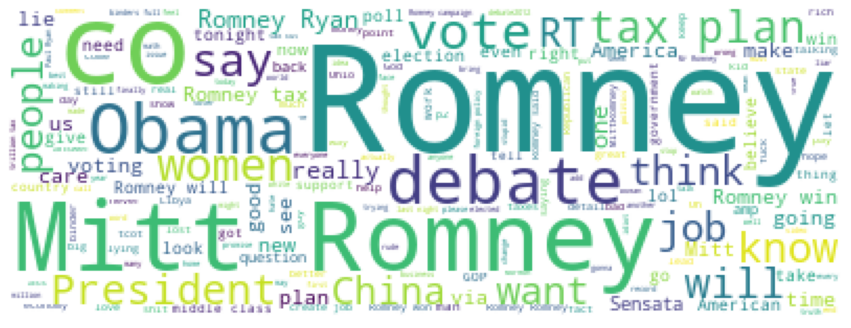

In [111]:
wordcloud(' '.join(tweets_rom))

['insidiousmitt romneys bain helped philip morris get us high schoolers hooked on cigarettes via '
 ' you mean like romney cheated in primary'
 'mitt romney still doesnt believe that we have a black president' ...
 'el  por ciento de las mujeres blancas casadas respaldan a romney'
 'and they brought us a whole binder of women oh romney' ' romneywon']


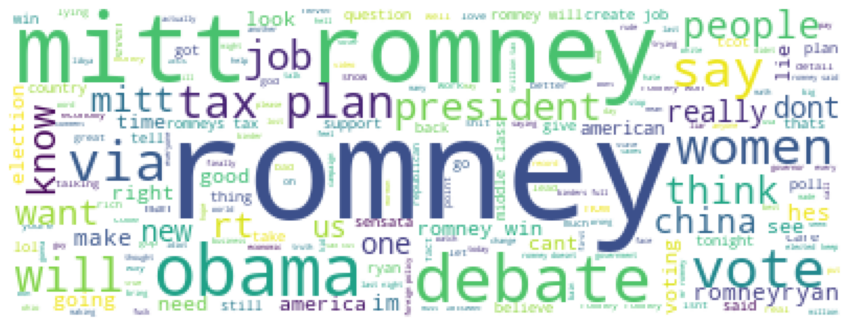

In [112]:
# Remove special char only
rom_rmspecial = tweet_cleaning(tweets_rom, '')
print(rom_rmspecial)
wordcloud(''.join(rom_rmspecial))

['insidiousmitt romney bain help philip morri get u high schooler hook on cigarett via'
 'you mean like romney cheat in primari'
 'mitt romney still doesnt believ that we have a black presid' ...
 'el por ciento de la mujer blanca casada respaldan a romney'
 'and they brought u a whole binder of woman oh romney' 'romneywon']


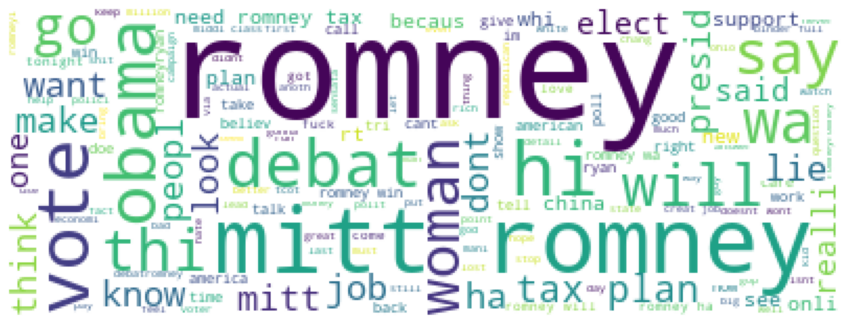

In [113]:
# Tweet stemmer_lemmatizer
rom_stemlem = tweet_cleaning(tweets_rom, 'stem_lem')
print(rom_stemlem)
wordcloud(''.join(rom_stemlem))

['insidiousmitt romney bain help philip morri get u high schooler hook cigarett via'
 'mean like romney cheat primari'
 'mitt romney still doesnt believ black presid' ...
 'el por ciento de la mujer blanca casada respaldan romney'
 'brought u whole binder woman oh romney' 'romneywon']


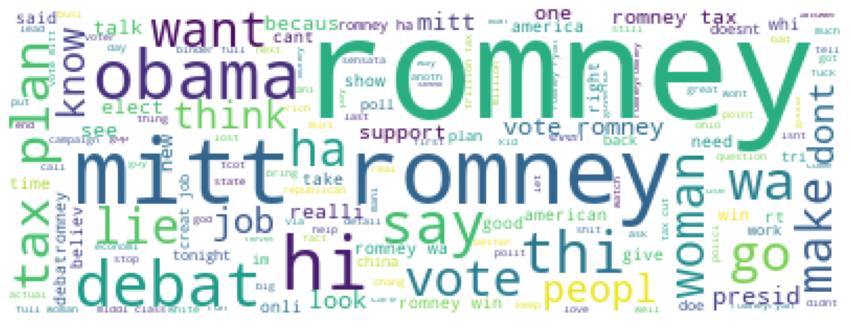

In [114]:
# Remove stopword
rom_rmstop = tweet_cleaning(tweets_rom, 'rm_stopwords')
print(rom_rmstop)
wordcloud(''.join(rom_rmstop))

['insidiousmitt romney bain help philip morri get u high schooler hook cigarett via'
 'mean like romney cheat primari'
 'mitt romney still doesnt believ black presid' ...
 'el por ciento de la mujer blanca casada respaldan romney'
 'brought u whole binder woman oh romney' 'romneywon']


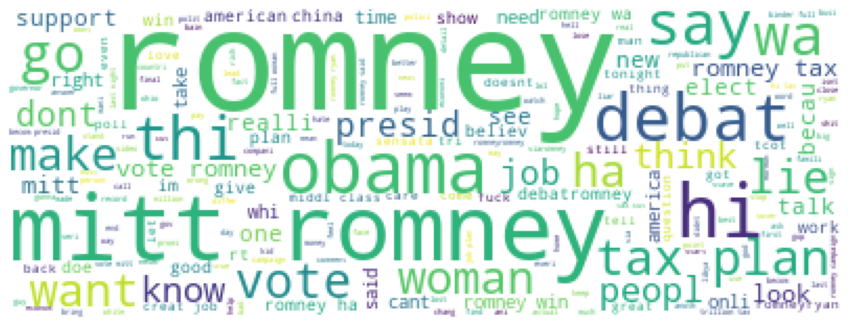

In [115]:
# All cleaning methods
rom_cleanall = tweet_cleaning(tweets_rom, 'all')
print(rom_cleanall)
wordcloud(''.join(rom_cleanall))

In [116]:
save_dataset(rom_cleanall, targets_rom, 'tweets_rom', 'targets_rom')

Saving training dataset...
Saved parsed dataset


## Data Vectorization

In [117]:
train_X, test_X, train_Y, test_Y = train_test_split(oba_cleanall, targets_oba, test_size = 0.2, random_state = 42)

### TF-IDF vectorizer

In [118]:
#tfv = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
tfv = TfidfVectorizer()
train_tfv = tfv.fit_transform(train_X)
test_tfv = tfv.transform(test_X)

In [119]:
vocab = tfv.get_feature_names()
print(vocab[:5])
print("Vocabulary length:", len(vocab))
dist = np.sum(train_tfv, axis=0)
checking = pd.DataFrame(dist, columns = vocab)
checking

['aa', 'aaaand', 'aaron', 'ab', 'abandon']
Vocabulary length: 6175


,aa,aaaand,aaron,ab,abandon,abba,abc,abcfox,abcpolit,abe,...,zerohedg,zesti,zien,zinger,zippedexcept,zipper,zombi,zwei,zzz,zzzzzzzzzz
0,0.433046,0.492133,0.309495,0.448678,1.127206,0.290708,5.77754,0.396907,0.409914,0.326947,...,0.481234,0.583062,0.262956,0.445127,0.391942,0.369544,0.922398,0.35337,0.586007,0.992812


In [120]:
tfv.idf_

array([8.7186855, 8.7186855, 8.7186855, ..., 8.7186855, 8.7186855,
       8.7186855])

### Count Vector

In [121]:
cv = CountVectorizer()
train_cv = cv.fit_transform(train_X)
test_cv = cv.transform(test_X)

In [122]:
cvocab = cv.get_feature_names()
print(cvocab[:5])

['aa', 'aaaand', 'aaron', 'ab', 'abandon']


### Train Models

##### MLP Classifier

In [123]:
MLP = MLPClassifier(random_state = 42)

mlp_param_grid = {
    'hidden_layer_sizes':[(5)],
    'activation':['relu'],
    'solver':['adam'],
    'alpha':[0.3],
    'learning_rate':['constant'],
    'max_iter':[1000]
}

kfold = StratifiedKFold( n_splits = 5, random_state = 42, shuffle=True )
gsMLP = GridSearchCV(MLP, param_grid = mlp_param_grid, cv = kfold, n_jobs= 1, verbose = 1)
gsMLP.fit(train_tfv, train_Y)
print(gsMLP.best_params_)
mlp_best0 = gsMLP.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'activation': 'relu', 'alpha': 0.3, 'hidden_layer_sizes': 5, 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.8s finished


In [160]:
gsMLP.best_score_
MLP_Y_predict = gsMLP.predict(test_tfv)
print("MLP Classifier - Training Result")
print(classification_report(gsMLP.predict(train_tfv),train_Y,digits=4))
print("MLP Classifier - Validation Result")
print(classification_report(MLP_Y_predict,test_Y, digits=4))


MLP Classifier - Training Result
              precision    recall  f1-score   support

          -1     0.9759    0.9680    0.9720      1593
           0     0.9508    0.9723    0.9614      1550
           1     0.9670    0.9513    0.9591      1356

    accuracy                         0.9644      4499
   macro avg     0.9646    0.9639    0.9642      4499
weighted avg     0.9646    0.9644    0.9644      4499

MLP Classifier - Validation Result
              precision    recall  f1-score   support

          -1     0.6314    0.5778    0.6034       424
           0     0.5026    0.5353    0.5184       368
           1     0.5536    0.5736    0.5634       333

    accuracy                         0.5627      1125
   macro avg     0.5625    0.5622    0.5618      1125
weighted avg     0.5662    0.5627    0.5638      1125



##### Logistic Regression

In [157]:
from sklearn import linear_model

logisticReg = linear_model.LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
logisticReg.fit(train_tfv, train_Y)

LogisticRegression(class_weight='balanced', max_iter=10000)

In [158]:
Y_predict=logisticReg.predict(test_tfv)

In [159]:
print("Logistic Regression - Training Result")
print(classification_report(logisticReg.predict(train_tfv),train_Y,digits=4))
print("Logistic Regression - Validation Result")
print(classification_report(Y_predict,test_Y, digits=4))

Logistic Regression - Training Result
              precision    recall  f1-score   support

          -1     0.8722    0.8470    0.8594      1627
           0     0.8114    0.8660    0.8378      1485
           1     0.8621    0.8291    0.8453      1387

    accuracy                         0.8477      4499
   macro avg     0.8485    0.8474    0.8475      4499
weighted avg     0.8490    0.8477    0.8479      4499

Logistic Regression - Validation Result
              precision    recall  f1-score   support

          -1     0.6160    0.5829    0.5990       410
           0     0.5306    0.5561    0.5431       374
           1     0.5913    0.5982    0.5948       341

    accuracy                         0.5787      1125
   macro avg     0.5793    0.5791    0.5789      1125
weighted avg     0.5801    0.5787    0.5791      1125



##### Linear Support Vector Classification

In [155]:
from sklearn import svm
clf = svm.LinearSVC(max_iter=2000)
clf.fit(train_tfv, train_Y)

LinearSVC(max_iter=2000)

In [156]:
clf_Y_predict = clf.predict(test_tfv)
print("Linear Support Vector Classification - Training Result")
print(classification_report(clf.predict(train_tfv),train_Y,digits=4))
print("Linear Support Vector Classification - Validation Result")
print(classification_report(clf_Y_predict,test_Y, digits=4))

Linear Support Vector Classification - Training Result
              precision    recall  f1-score   support

          -1     0.9620    0.9429    0.9524      1612
           0     0.9249    0.9557    0.9400      1534
           1     0.9438    0.9305    0.9371      1353

    accuracy                         0.9435      4499
   macro avg     0.9436    0.9430    0.9432      4499
weighted avg     0.9439    0.9435    0.9436      4499

Linear Support Vector Classification - Validation Result
              precision    recall  f1-score   support

          -1     0.6366    0.5812    0.6076       425
           0     0.5128    0.5346    0.5234       376
           1     0.5565    0.5926    0.5740       324

    accuracy                         0.5689      1125
   macro avg     0.5686    0.5694    0.5684      1125
weighted avg     0.5721    0.5689    0.5698      1125



##### Random Forest Classifier

In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

print("Random Forest Classifier - Training Result")
print(classification_report(model.predict(train_tfv),train_Y,digits=4))

print("Random Forest Classifier - Validation Result")
print(classification_report(y_pred,test_Y, digits=4))

Training Accuracy : 0.9919982218270726
Validation Accuracy : 0.5831111111111111
[[224 106  58]
 [ 84 228  80]
 [ 46  95 204]]
Random Forest Classifier - Training Result
              precision    recall  f1-score   support

          -1     0.9943    0.9962    0.9952      1577
           0     0.9861    0.9924    0.9892      1575
           1     0.9963    0.9866    0.9914      1347

    accuracy                         0.9920      4499
   macro avg     0.9922    0.9917    0.9920      4499
weighted avg     0.9920    0.9920    0.9920      4499

Random Forest Classifier - Validation Result
              precision    recall  f1-score   support

          -1     0.5773    0.6328    0.6038       354
           0     0.5816    0.5315    0.5554       429
           1     0.5913    0.5965    0.5939       342

    accuracy                         0.5831      1125
   macro avg     0.5834    0.5869    0.5844      1125
weighted avg     0.5832    0.5831    0.5823      1125



##### Decision Tree Classifier

In [149]:
model = DecisionTreeClassifier()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

print("Training Result")
print(classification_report(model.predict(train_tfv), train_Y, digits=4))

print("Decision Tree Classifier")
print(classification_report(y_pred,test_Y, digits=4))

Training Accuracy : 0.9919982218270726
Validation Accuracy : 0.48
[[172 131  85]
 [ 92 192 108]
 [ 71  98 176]]
Training Result
              precision    recall  f1-score   support

          -1     0.9981    0.9924    0.9953      1589
           0     0.9849    0.9936    0.9892      1571
           1     0.9933    0.9895    0.9914      1339

    accuracy                         0.9920      4499
   macro avg     0.9921    0.9919    0.9920      4499
weighted avg     0.9920    0.9920    0.9920      4499

Decision Tree Classifier
              precision    recall  f1-score   support

          -1     0.4433    0.5134    0.4758       335
           0     0.4898    0.4561    0.4723       421
           1     0.5101    0.4770    0.4930       369

    accuracy                         0.4800      1125
   macro avg     0.4811    0.4822    0.4804      1125
weighted avg     0.4826    0.4800    0.4801      1125



##### Linear Support Vector Classification

In [132]:
from sklearn.svm import SVC

model = SVC()
model.fit(train_tfv, train_Y)

y_pred = model.predict(test_tfv)

print("Training Accuracy :", model.score(train_tfv, train_Y))
print("Validation Accuracy :", model.score(test_tfv, test_Y))

# calculating the f1 score for the validation set
#print("F1 score :", f1_score(test_Y, y_pred))

# confusion matrix
cm = confusion_matrix(test_Y, y_pred)
print(cm)

Training Accuracy : 0.9586574794398756
Validation Accuracy : 0.5964444444444444
[[263  89  36]
 [115 224  53]
 [ 66  95 184]]


In [133]:
kfold = StratifiedKFold( n_splits = 5, random_state = 42, shuffle=True )
print(kfold)
sv = LinearSVC(random_state=2018)

param_grid2 = {
    'loss':['squared_hinge'],
    'class_weight':[{1:4}],
    'C': [0.2]
}
sv.fit(train_tfv, train_Y)
accuracy_score(test_Y, sv.predict(test_tfv))

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


0.5688888888888889

##### Gaussian Naive Bayes

In [161]:
from sklearn.naive_bayes import GaussianNB

pipeline = Pipeline([
    ('clf', GaussianNB())
])

parameters = {
    'clf__priors': [None],
    'clf__var_smoothing': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
}

cv = GridSearchCV(pipeline, param_grid=parameters, scoring='accuracy')

# gnb = GaussianNB()
Y_pred_Bayes = cv.fit(train_tfv.toarray(), train_Y).predict(test_tfv.toarray())
print(cv.best_params_)
print(cv.best_score_)
print("Gaussian Naive Bayes - Training Result")
print(classification_report(cv.predict(train_tfv.toarray()), train_Y, digits=4))
print("Gaussian Naive Bayes - Validation Result")
print(classification_report(Y_pred_Bayes,test_Y, digits=4))


{'clf__priors': None, 'clf__var_smoothing': 0.001}
0.48121270547521944
Gaussian Naive Bayes - Training Result
              precision    recall  f1-score   support

          -1     0.8563    0.9370    0.8948      1444
           0     0.7621    0.9894    0.8610      1221
           1     0.9993    0.7268    0.8415      1834

    accuracy                         0.8655      4499
   macro avg     0.8726    0.8844    0.8658      4499
weighted avg     0.8890    0.8655    0.8639      4499

Gaussian Naive Bayes - Validation Result
              precision    recall  f1-score   support

          -1     0.4923    0.5411    0.5155       353
           0     0.3342    0.4662    0.3893       281
           1     0.6435    0.4521    0.5311       491

    accuracy                         0.4836      1125
   macro avg     0.4900    0.4865    0.4786      1125
weighted avg     0.5188    0.4836    0.4908      1125

